# Compute correlation function with error bars using log-normal mocks

In [5]:
import time
from tqdm.notebook import tqdm

import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction

import catalog_data
import density_split
from density_split_mocks_functions import split_density, compute_densitySplit_CCF

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

## Split density

In [5]:
cellsize = 20
resampler = 'tsc'

catalog_density = split_density(catalog, cellsize, resampler, nsplits=2, save=False, output_dir=output_dir)

edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))
catalog_CCFs = compute_densitySplit_CCF(catalog_density, edges, los='x')

ells = (0, 2)
nells = len(ells)
catalog_split_xiell_gg = [result.get_corr(ells=ells, return_sep=False) for result in catalog_CCFs['gg']]
catalog_split_xiell_dg = [result.get_corr(ells=ells, return_sep=False) for result in catalog_CCFs['dg']]

## Generate log-normal mocks and compute cross-correlation function on density splits

In [7]:
results_gg = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF')
results_dg = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_dg_CCF')

NameError: name 'results_gg' is not defined

In [6]:
test = np.array([[1, 2, 1, 5, 6, 2, 3], [1, 2, 1, 4, 6, 2, 5]])

In [16]:
corr = [[test, test], [test, test]]

## Compute covariance matrix

In [20]:
def get_poles(results, ells):
    nells = len(ells)
    n = len(results)
    nsplits = len(results[0])
    
    xiell = list()
    cov = list()
    
    for i in range(nsplits):
        #results_poles = [np.ravel(res[i].get_corr(ells=ells, return_sep=False)) for res in results]
        results_poles = [np.ravel(res[i]) for res in results]
        print(results_poles)
        poles = np.mean(results_poles, axis=0)
        print(poles)
        xiell.append(poles.reshape((nells, len(poles)//nells)))
    
    cov = np.cov([np.ravel(res) for res in results], rowvar=False)

    return xiell, cov

In [21]:
poles, cv = get_poles(corr, (0, 2))

[array([1, 2, 1, 5, 6, 2, 3, 1, 2, 1, 4, 6, 2, 5]), array([1, 2, 1, 5, 6, 2, 3, 1, 2, 1, 4, 6, 2, 5])]
[1. 2. 1. 5. 6. 2. 3. 1. 2. 1. 4. 6. 2. 5.]
[array([1, 2, 1, 5, 6, 2, 3, 1, 2, 1, 4, 6, 2, 5]), array([1, 2, 1, 5, 6, 2, 3, 1, 2, 1, 4, 6, 2, 5])]
[1. 2. 1. 5. 6. 2. 3. 1. 2. 1. 4. 6. 2. 5.]


In [24]:
[np.ravel(res) for res in corr]

[array([1, 2, 1, 5, 6, 2, 3, 1, 2, 1, 4, 6, 2, 5, 1, 2, 1, 5, 6, 2, 3, 1,
        2, 1, 4, 6, 2, 5]),
 array([1, 2, 1, 5, 6, 2, 3, 1, 2, 1, 4, 6, 2, 5, 1, 2, 1, 5, 6, 2, 3, 1,
        2, 1, 4, 6, 2, 5])]

In [19]:
ells = (0, 2)
nells = len(ells)

xiell_gg, cov_gg = get_poles(results_gg, ells)
xiell_dg, cov_dg = get_poles(results_dg, ells)

In [25]:
std_gg = [np.array_split(np.diag(cov_gg[i])**0.5, nells) for i in range(len(cov_gg))]
std_dg = [np.array_split(np.diag(cov_dg[i])**0.5, nells) for i in range(len(cov_gg))]

## Plot correlation function with error bars

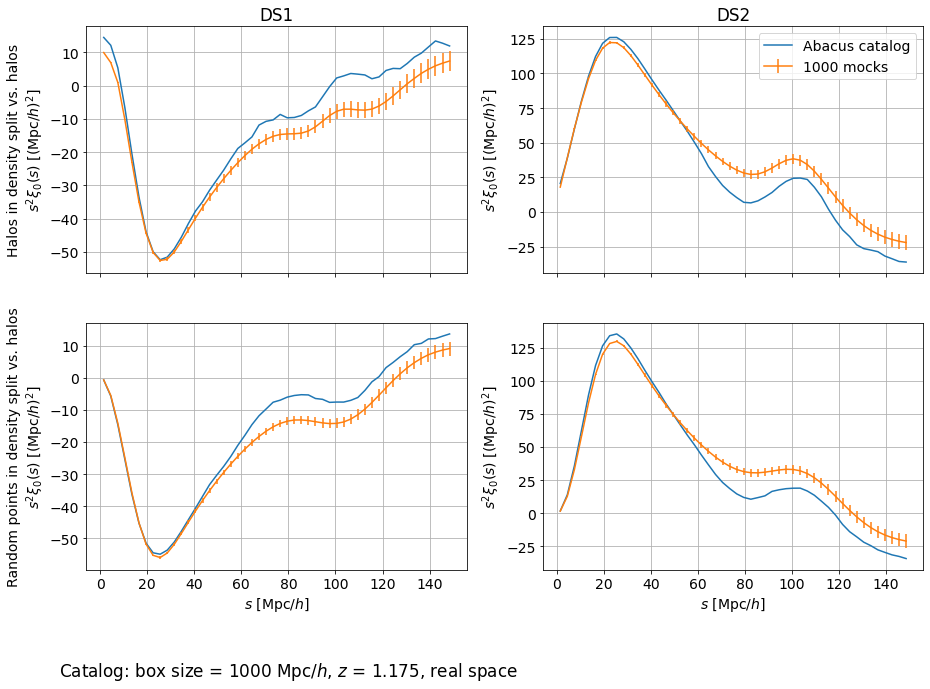

In [29]:
plt.rcParams["figure.figsize"] = (15, 10)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False)

for i in range(catalog_density.nsplits):
    
    axes[0][i].plot(s, s**2 * catalog_split_xiell_gg[i][0], label='Abacus catalog')
    axes[0][i].errorbar(s, s**2 * xiell_gg[i][0], s**2 * std_gg[i][0], fmt='-', label='{} mocks'.format(nmocks))
    axes[0][i].grid(True)

    axes[1][i].plot(s, s**2 * catalog_split_xiell_dg[i][0], label='Abacus catalog')
    axes[1][i].errorbar(s, s**2 * xiell_dg[i][0], s**2 * std_dg[i][0], fmt='-', label='{} mocks'.format(nmocks))
    axes[1][i].grid(True)

    axes[0][i].set_title('DS{}'.format(i+1))    
    axes[1][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0][0].set_ylabel('Halos in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel('Random points in density split vs. halos' + '\n'
                      + r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][1].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.redshift),
             ha='left', x=0.1, y=0)

axes[0][1].legend()
plt.show()